In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
path = 'hillary-clinton-emails/Emails.csv'
data = pd.read_csv(path, sep=',')

In [4]:
data.dropna(subset=['ExtractedBodyText'], inplace=True)
data.dropna(subset=['ExtractedSubject'], inplace=True)

In [5]:
def getRawText():
    subjectData = data[data.ExtractedSubject.notnull()].ExtractedSubject.astype(str)
    bodyData = data[data.ExtractedBodyText.notnull()].ExtractedBodyText.astype(str)
    rawText = ' '.join(subjectData) + ' ' + ' '.join(bodyData)
    rawText = rawText.replace('\n', ' ')
    return rawText

## 1. Generate a word cloud based on the raw corpus 

### 1.1 Word cloud without preprocessing

In [6]:
rawText = getRawText()

In [7]:
wordcloud = WordCloud().generate(rawText)

(-0.5, 399.5, 199.5, -0.5)

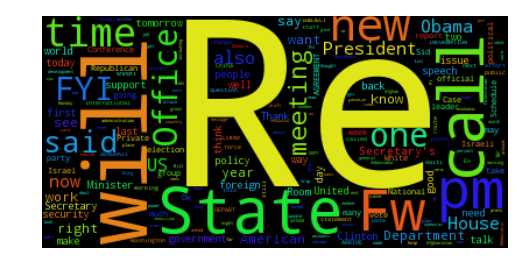

In [8]:
plt.imshow(wordcloud)
plt.axis("off")

### 1.2 Word cloud with preprocessing 

In [13]:
def filterStopWords(text):
    try:
        tokens = nltk.word_tokenize(text)
    except:
        nltk.download()
        tokens = nltk.word_tokenize(text)
    stopWords = stopwords.words('english')
    customWords = ['re','fwd','pm','am', 'also', 'and', 'fyi', 'tomorrow', 'today',
                   'well', '.', ',', '"', "'", '?', '&','/', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}', '@', '<', '>', '-', "n't"]
    stopWords += customWords
    filtered = list()
    for token in tokens:
        token = token.lower()
        if token not in stopWords:
            filtered.append(token)
    return filtered

#http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
def lemmAndStem(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
    stemmed = [stemmer.stem(lema) for lema in lemmatized]
    return stemmed

def preprocess(text):
    filtered = filterStopWords(text)
    processed = lemmAndStem(filtered)
    return ' '.join(processed)

In [14]:
procText = preprocess(rawText)

(-0.5, 399.5, 199.5, -0.5)

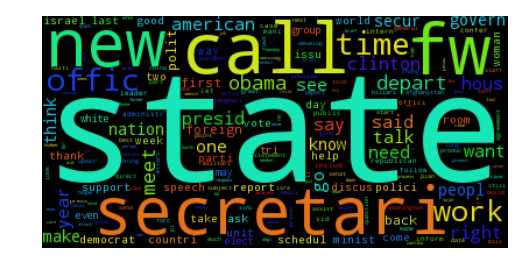

In [15]:
wordcloud = WordCloud().generate(procText)
plt.imshow(wordcloud)
plt.axis("off")

## 2. Sentiment Analysis

https://www.kaggle.com/operdeck/d/kaggle/hillary-clinton-emails/hillary-s-sentiment-about-countries

In [77]:
import pycountry
list_countries = list(pycountry.countries)
accumulator = {}
list_token = clean_text(rawText).split()
for country in list_countries:
    suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) + list_token.count(country.alpha_3.lower().lower())
    accumulator[country.name] = suma

In [78]:
proba = pd.Series(accumulator, dtype='str')
proba 

Afghanistan                              271
Albania                                   67
Algeria                                    3
American Samoa                             0
Andorra                                   12
Angola                                   135
Anguilla                                   2
Antarctica                                14
Antigua and Barbuda                        2
Argentina                                 21
Armenia                                    9
Aruba                                      1
Australia                                 18
Austria                                    2
Azerbaijan                                14
Bahamas                                    1
Bahrain                                    4
Bangladesh                                10
Barbados                                  11
Belarus                                    0
Belgium                                    4
Belize                                     0
Benin     

In [22]:
for i in list(pycountry.countries):
    print(i)

Country(alpha_2='AW', alpha_3='ABW', name='Aruba', numeric='533')
Country(alpha_2='AF', alpha_3='AFG', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan')
Country(alpha_2='AO', alpha_3='AGO', name='Angola', numeric='024', official_name='Republic of Angola')
Country(alpha_2='AI', alpha_3='AIA', name='Anguilla', numeric='660')
Country(alpha_2='AX', alpha_3='ALA', name='Åland Islands', numeric='248')
Country(alpha_2='AL', alpha_3='ALB', name='Albania', numeric='008', official_name='Republic of Albania')
Country(alpha_2='AD', alpha_3='AND', name='Andorra', numeric='020', official_name='Principality of Andorra')
Country(alpha_2='AE', alpha_3='ARE', name='United Arab Emirates', numeric='784')
Country(alpha_2='AR', alpha_3='ARG', name='Argentina', numeric='032', official_name='Argentine Republic')
Country(alpha_2='AM', alpha_3='ARM', name='Armenia', numeric='051', official_name='Republic of Armenia')
Country(alpha_2='AS', alpha_3='ASM', name='American Samoa', n

## Clean Data

In [99]:
import re
def clean_days_month(text):
    week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'September',
                 'November', 'December']
    hours = ['AM', 'PM']    
    return [word for word in text if word not in (week_days + months + hours)]

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def word_contains_number(word):
    return any(ch.isdigit() for ch in word)    
        
def clean_numbers(text):
    return [word for word in text if not is_number(word) and not word_contains_number(word) ]

def clean_symbol(text):
    tmp = [re.sub(r'[\w\.-]+@[\w\.-]+', '', word)for word in text]
    return [re.sub('[!@#$,:<>\().]', '', word) for word in tmp]

def clean_text(text):
    tmp = clean_symbol(text.split())
    tmp = filterStopWords(' '.join(clean_days_month(tmp)))
    return ' '.join(clean_numbers(tmp))


Clean data and tranform the strings to tokens

In [97]:
from nltk.sentiment.util import *
to_token = nltk.tokenize.RegexpTokenizer(r'\w+|\$')
#Cleaning Body of emails
tmp = []
for i in data.ExtractedBodyText.values:
    tmp.append(clean_text(i) )
data['token_Body'] = tmp
data['token_Body'] = data['token_Body'].apply(to_token.tokenize)
#Cleanning Subject of emails
tmp = []
for i in data.ExtractedSubject.values:
    tmp.append(clean_text(i) )
data['token_Subject'] = tmp
data['token_Subject'] = data['token_Subject'].apply(to_token.tokenize)

In [120]:
def flatten(list1):
    return [ list1[x][y] for x in range(len(list1)) for y in range(len(list1[x]))]


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pycountry

full_text =  data['token_Body'] #data['token_Subject'] +
list_token = flatten(full_text.values.tolist())
text_token = ' '.join(list_token)
sentiment = (SentimentIntensityAnalyzer().polarity_scores(text_token))#['compound']+1)/2
sentiment
'''
list_countries = list(pycountry.countries)
accumulator = {}
for country in list_countries:
    
    suma =  list_token.count(country.name.lower()) + list_token.count(country.alpha_2.lower()) + list_token.count(country.alpha_3.lower())
    accumulator[country.name] = suma
    '''

In [ ]:
dataset = pd.Series(accumulator, dtype='str')
proba